Inference

✅ Model Loaded Successfully!


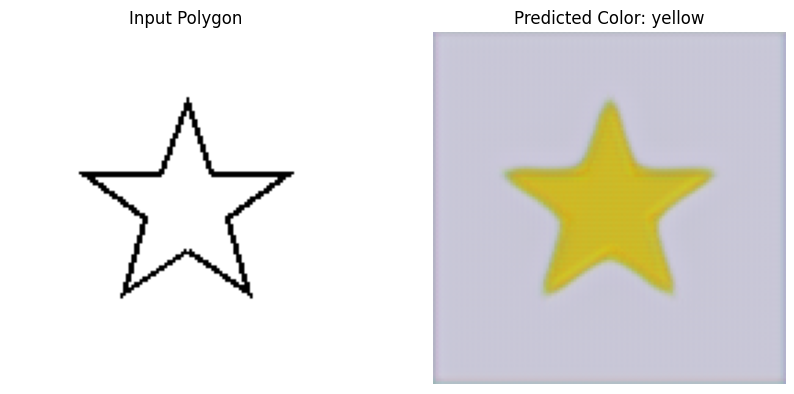

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from model import UNetConditional

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


colors = ["cyan","red", "green", "blue", "yellow", "purple","orange","magenta"]

color_to_idx = {c: i for i, c in enumerate(colors)}

model = UNetConditional(in_channels=1, out_channels=3, embed_dim=len(colors)).to(device)
model.load_state_dict(torch.load("/content/unet_polygon_color.pth", map_location=device))
model.eval()

print(" Model Loaded Successfully!")


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("L")
    return transform(img).unsqueeze(0)  # shape: [1,1,H,W]

def get_color_embedding(color_name):
    color_idx = color_to_idx[color_name]
    color_onehot = torch.zeros(len(colors))
    color_onehot[color_idx] = 1.0
    return color_onehot.unsqueeze(0)  # shape: [1, embed_dim]


def predict_colored_polygon(input_image_path, color_name):
    input_tensor = preprocess_image(input_image_path).to(device)
    color_embedding = get_color_embedding(color_name).to(device)

    with torch.no_grad():
        output = model(input_tensor, color_embedding)

    output_image = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # HWC
    output_image = np.clip(output_image, 0, 1)

    return output_image


example_image = "/content/drive/MyDrive/dataset/validation/inputs/star.png"
example_color = "yellow"

predicted_image = predict_colored_polygon(example_image, example_color)

input_img = Image.open(example_image).convert("L")
input_img_resized = transform(input_img).squeeze(0).numpy()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Input Polygon")
plt.imshow(input_img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Predicted Color: {example_color}")
plt.imshow(predicted_image)
plt.axis("off")
plt.show()


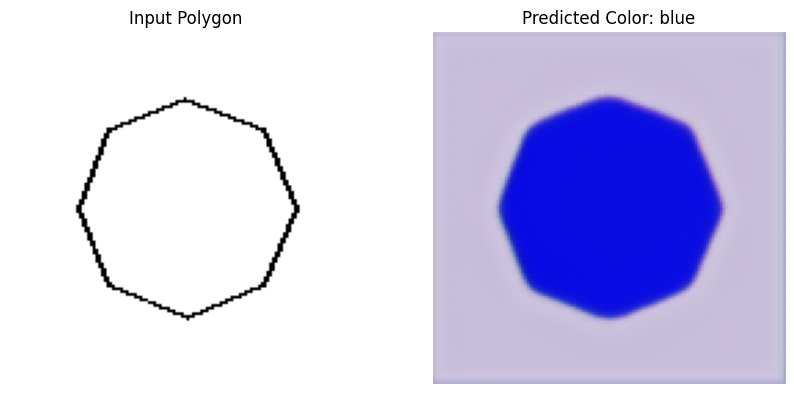

In [ ]:
example_image = "/content/drive/MyDrive/dataset/validation/inputs/octagon.png"
example_color = "blue"

predicted_image = predict_colored_polygon(example_image, example_color)

input_img = Image.open(example_image).convert("L")
input_img_resized = transform(input_img).squeeze(0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Input Polygon")
plt.imshow(input_img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Predicted Color: {example_color}")
plt.imshow(predicted_image)
plt.axis("off")
plt.show()

Additional Model validation techniques

✅ Model Loaded Successfully!
PSNR: 14.08 dB
SSIM: 0.8726


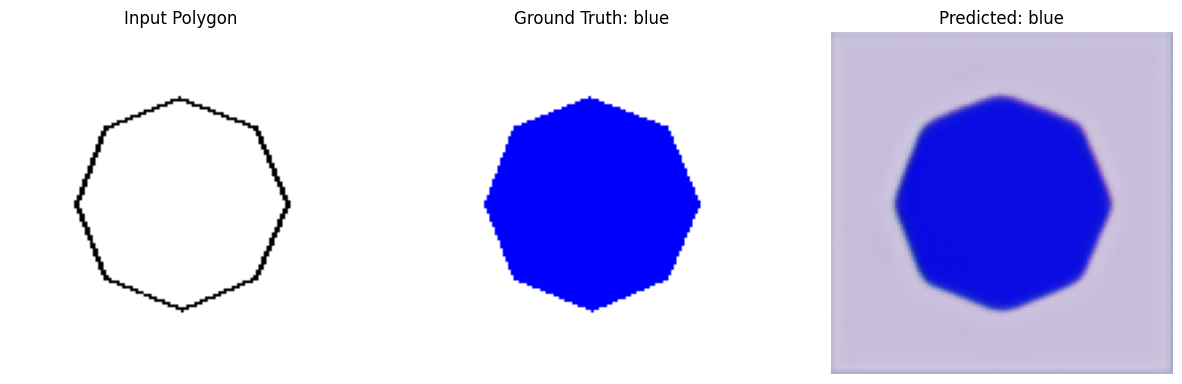

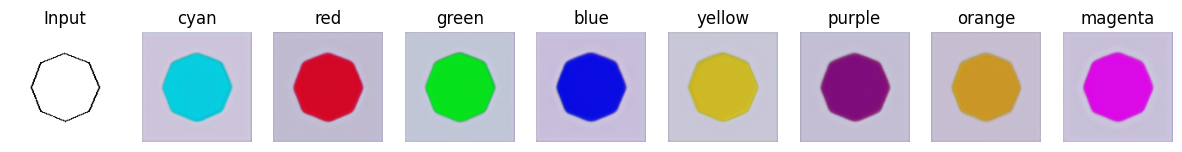

In [ ]:

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from model import UNetConditional
from math import log10
from skimage.metrics import structural_similarity as ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


colors = ["cyan","red", "green", "blue", "yellow", "purple","orange","magenta"]
color_to_idx = {c: i for i, c in enumerate(colors)}

model = UNetConditional(in_channels=1, out_channels=3, embed_dim=len(colors)).to(device)
model.load_state_dict(torch.load("/content/unet_polygon_color.pth", map_location=device))
model.eval()

print("✅ Model Loaded Successfully!")


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert("L")
    return transform(img).unsqueeze(0)

def preprocess_target(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0)

def get_color_embedding(color_name):
    color_idx = color_to_idx[color_name]
    color_onehot = torch.zeros(len(colors))
    color_onehot[color_idx] = 1.0
    return color_onehot.unsqueeze(0)

def predict_colored_polygon(input_image_path, color_name):
    input_tensor = preprocess_image(input_image_path).to(device)
    color_embedding = get_color_embedding(color_name).to(device)

    with torch.no_grad():
        output = model(input_tensor, color_embedding)

    output_image = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # HWC
    return np.clip(output_image, 0, 1)


def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * log10(1 / mse)

def calculate_ssim(img1, img2):
    img1_gray = np.dot(img1[..., :3], [0.2989, 0.5870, 0.1140])
    img2_gray = np.dot(img2[..., :3], [0.2989, 0.5870, 0.1140])
    return ssim(img1_gray, img2_gray, data_range=1.0)


example_image = "/content/drive/MyDrive/dataset/validation/inputs/octagon.png"
ground_truth_image = "/content/drive/MyDrive/dataset/validation/outputs/blue_octagon.png"
example_color = "blue"

predicted_image = predict_colored_polygon(example_image, example_color)


gt_image = Image.open(ground_truth_image).convert("RGB")
gt_image_resized = transform(gt_image).squeeze(0).numpy().transpose(1, 2, 0)

psnr_value = calculate_psnr(predicted_image, gt_image_resized)
ssim_value = calculate_ssim(predicted_image, gt_image_resized)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


input_img = Image.open(example_image).convert("L")
input_img_resized = transform(input_img).squeeze(0).numpy()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Input Polygon")
plt.imshow(input_img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Ground Truth: {example_color}")
plt.imshow(gt_image_resized)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Predicted: {example_color}")
plt.imshow(predicted_image)
plt.axis("off")
plt.show()


multi_colors = ["cyan","red", "green", "blue", "yellow", "purple","orange","magenta"]

plt.figure(figsize=(15, 8))
plt.subplot(1, len(multi_colors) + 1, 1)
plt.title("Input")
plt.imshow(input_img_resized, cmap="gray")
plt.axis("off")

for i, c in enumerate(multi_colors):
    pred = predict_colored_polygon(example_image, c)
    plt.subplot(1, len(multi_colors) + 1, i + 2)
    plt.title(c)
    plt.imshow(pred)
    plt.axis("off")

plt.show()
